In [1]:
from common import SystemConfig
from dynamics import ContinuousLQREnv
from estimator import ContinuousLeastSquaresEstimator
from planner import RiccatiODESolver

import matplotlib.pyplot as plt
import numpy as np

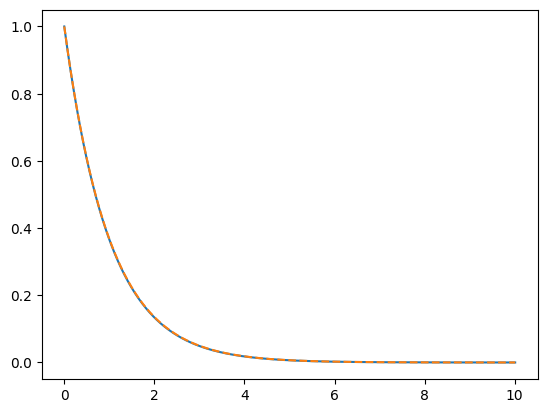

In [2]:
# Sanity check: x'(t) = -x(t) should give exp(-t)
A = np.array([[-1.0]])
B = np.array([[0.0]])
sigma = np.array([[0.0]])
x0 = np.array([1.0])
config = SystemConfig(x_dim=1, u_dim=1, dt=0.01, T=10)
env = ContinuousLQREnv(A, B, sigma, x0, config)
t_vals = [env.t]
x_vals = [x0.item()]
t = 0.0

while t < config.T:
    t += config.dt
    x, _, _ = env.step(np.array([0.0]))
    t_vals.append(t)
    x_vals.append(x.item())

plt.plot(t_vals, x_vals)
plt.plot(t_vals, np.exp(-np.array(t_vals)), linestyle='--')

In [3]:
def learn(A_true, B_true, sigma, x0, Q, R, config, cycles=5):
    env = ContinuousLQREnv(A_true, B_true, sigma, x0, config)
    estimator = ContinuousLeastSquaresEstimator(config)  # note: using all past trajectories as opposed to only current cycle's to decrease variance, even though this now correlates trajectories across epochs
    riccati = RiccatiODESolver(config, Q, R)

    # shadow simulation to obtain "what-if-i-had-behaved-optimally" cost
    env_shadow = ContinuousLQREnv(A_true, B_true, sigma, x0, config)
    riccati_opt = RiccatiODESolver(config, Q, R)
    riccati_opt.solve(A_true, B_true)

    def cost_function(x, u):
        return x.T @ Q @ x + u.T @ R @ u

    # zero initialisation of parameters (leads to u = 0 in the first cycle)
    A_hat = np.zeros_like(A_true)
    B_hat = np.zeros_like(B_true)

    # Schedule: Double episodes each cycle
    m0 = 4

    print(f"{'Cycle':<5} | {'Episodes':<8} | {'Param Error':<12} | {'Avg Cost':<10}")
    print("-" * 45)

    results = {
        "costs": [],
        "regrets": [],
        "thetas": [],
        "m_l" : [],
    }

    for l in range(cycles):
        m_l = m0 * (2**l)  # Theory requires duration T_l to grow geometrically.

        # 1. Update Policy
        # Solve Riccati using CURRENT best estimates
        riccati.solve(A_hat, B_hat)

        # 2. Schedule Exploration (Dithering)
        # As our estimates get better (l increases), we reduce noise.
        # But we never turn it off completely (to maintain rank).
        exploration_std = 1.0 / np.sqrt(l + 1)

        cycle_costs = []
        cycle_regrets = []

        # Step 2: Execute m_l episodes
        for _ in range(m_l):
            state = env.reset()
            _ = env_shadow.reset()
            state_shadow = state.copy()
            trajectory = []
            episode_cost = 0.0
            episode_regret = 0.0

            # Simulate Episode
            while env.t < config.T:
                # Compute Control u = K(t)x
                u = riccati.get_K(env.t, B_hat) @ state

                # b. Add Exploration Noise (Excitation)
                u += np.random.normal(0, exploration_std, size=config.u_dim)

                cost_learner = cost_function(state, u)
                
                # Environment step
                shared_noise = np.random.normal(size=config.x_dim)
                new_state, dx, dt = env.step(u, noise_override=shared_noise)

                # Record Data
                trajectory.append((state.copy(), u, dx, dt))
                state = new_state

                # Shadow simulation
                u_opt = riccati_opt.get_K(env_shadow.t, B_true) @ state_shadow
                cost_opt = cost_function(state_shadow, u_opt)
                state_shadow, _, _ = env_shadow.step(u_opt, noise_override=shared_noise)

                # Accumulate cost and regret
                episode_cost += cost_learner * dt
                episode_regret += (cost_learner - cost_opt) * dt

            estimator.add_trajectory(trajectory)
            
            cycle_costs.append(episode_cost.item())
            cycle_regrets.append(episode_regret.item())

        # Step 3: Update Estimation
        A_hat, B_hat = estimator.estimate()

        results["costs"].extend(cycle_costs)
        results["regrets"].extend(cycle_regrets)
        results["thetas"].append((A_hat, B_hat))
        results["m_l"].append(m_l)

        # Metrics
        err = np.linalg.norm(A_hat - A_true) + np.linalg.norm(B_hat - B_true)
        print(f"{l:<5} | {m_l:<8} | {err:<12.4f} | {np.mean(cycle_costs):<10.2f}")

    return results

Cycle | Episodes | Param Error  | Avg Cost  
---------------------------------------------
0     | 4        | 0.0227       | 133.82    
1     | 8        | 0.0057       | 4.21      
2     | 16       | 0.0119       | 3.31      
3     | 32       | 0.0086       | 2.92      
4     | 64       | 0.0070       | 2.67      
5     | 128      | 0.0116       | 2.54      
6     | 256      | 0.0104       | 2.39      
[[0.49312007]]
[[0.99650281]]


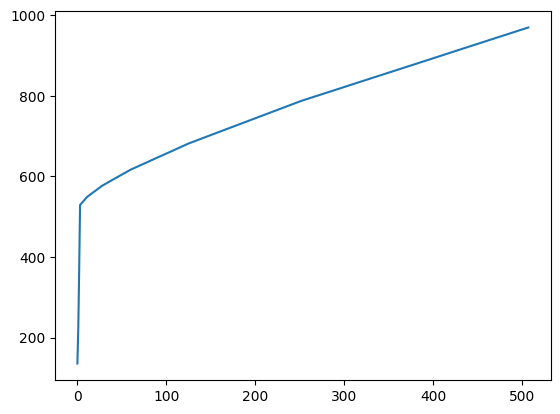

In [4]:
# Simple Scalar System: dx = (0.5x + u)dt + 0.1dw
config = SystemConfig(
    x_dim=1,
    u_dim=1,
    dt=0.001,
    T=5.0
)
A = np.array([[0.5]])
B = np.array([[1.0]])
sigma = np.array([[0.1]])
x0 = np.array([1.0])
Q = np.array([[1.0]])
R = np.array([[1.0]])

results = learn(A, B, sigma, x0, Q, R, config, cycles=7)

print(*results["thetas"][-1], sep="\n")
plt.plot(np.cumsum(results["regrets"]))

Cycle | Episodes | Param Error  | Avg Cost  
---------------------------------------------
0     | 4        | 0.0228       | 82.29     
1     | 8        | 0.0279       | 12.27     
2     | 16       | 0.0215       | 10.72     
3     | 32       | 0.0188       | 9.63      
4     | 64       | 0.0158       | 9.14      
5     | 128      | 0.0119       | 8.93      
6     | 256      | 0.0061       | 8.71      
[[-4.65674069e-05  9.99889187e-01]
 [ 2.03866932e-03  2.22399392e-03]]
[[-5.80638045e-04]
 [ 1.00299986e+00]]


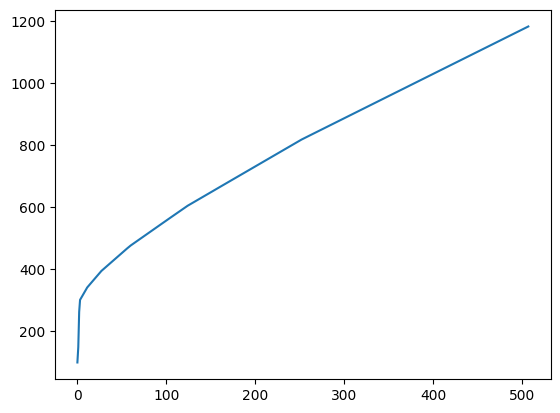

In [5]:
# Double Integrator: ds = v dt + 0.1dw, dv = u dt + 0.1dw
config = SystemConfig(
    x_dim=2,
    u_dim=1,
    dt=0.001,
    T=10.0
)
A = np.array([[0.0, 1.0], [0.0, 0.0]])
B = np.array([[0.0], [1.0]])
sigma = 0.1 * np.eye(2) # Small process noise
x0 = np.array([2.0, 0.0])  # Start away from origin to force the agent to act
Q = np.eye(2)
R = np.eye(1)

results = learn(A, B, sigma, x0, Q, R, config, cycles=7)

print(*results["thetas"][-1], sep="\n")
plt.plot(np.cumsum(results["regrets"]))